In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='Data', train=False, download=True, transform=transform)

C:\Users\shisk\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

In [8]:
len(train_loader)

6000

In [9]:
len(test_loader)

1000

### Define CNN Architecture

In [24]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [25]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
total_params = 0
for param in model.parameters():
    total_params+=param.numel()
    
print(f'total parameters: {total_params}')

total parameters: 60074


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
import time
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted_class = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted_class == y_train).sum()
        trn_corr+=batch_corr
        
        # update params
        optimizer.zero_grad()     # clear gradients since this is a new batch
        loss.backward()           # calculate gradients for given batch loss
        optimizer.step()          # apply gradients and update parameters
        
        if b%600 == 0:
            print(f'epoch:{i} batch:{b} loss:{loss.item()}')
    
    # for each epoch
    train_losses.append(loss.item()) # use '.item()' to convert tensor to number
    train_correct.append(trn_corr.item())

    # test after each epoch
    # use 'no_grad' since we won't be using loss.backward() with test 'y_val' to save memory
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test)
            
            predicted_class = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted_class == y_test).sum()
    
    # get test loss
    loss = criterion(y_val, y_test)
    test_losses.append(loss)        # don't need '.item()' as gradients were not calculated
    test_correct.append(tst_corr)

curr_time = time.time()
total_elapsed = curr_time - start_time
print(f'Training time: {total_elapsed/60} minutes')

epoch:0 batch:600 loss:4.0981420170282945e-05
epoch:0 batch:1200 loss:0.002016084734350443
epoch:0 batch:1800 loss:0.00040841015288606286
epoch:0 batch:2400 loss:0.0005360080976970494
epoch:0 batch:3000 loss:0.001113468548282981
epoch:0 batch:3600 loss:0.17167013883590698
epoch:0 batch:4200 loss:9.086998034035787e-05
epoch:0 batch:4800 loss:5.294506627251394e-05
epoch:0 batch:5400 loss:0.016773637384176254
epoch:0 batch:6000 loss:0.0024925211910158396
epoch:1 batch:600 loss:0.0011193571845069528
epoch:1 batch:1200 loss:0.0006056752172298729
epoch:1 batch:1800 loss:0.00013248043251223862
epoch:1 batch:2400 loss:0.0007207891321741045
epoch:1 batch:3000 loss:0.02356339432299137
epoch:1 batch:3600 loss:0.0023093644995242357
epoch:1 batch:4200 loss:0.0008823525859043002
epoch:1 batch:4800 loss:0.3251186013221741
epoch:1 batch:5400 loss:0.00019341557344887406
epoch:1 batch:6000 loss:0.00013883234350942075
epoch:2 batch:600 loss:0.0001860637858044356
epoch:2 batch:1200 loss:0.1498236358165741

### Plot Losses

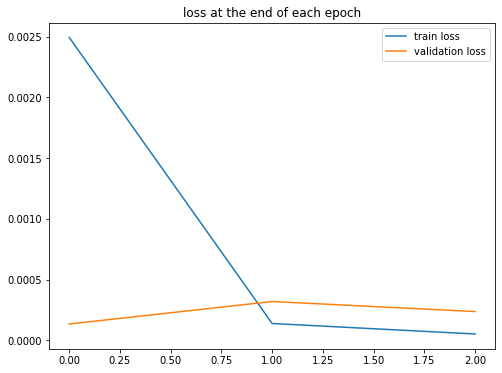

In [34]:
plt.figure(figsize = (8, 6))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label = 'validation loss')
plt.title('loss at the end of each epoch')
plt.legend()

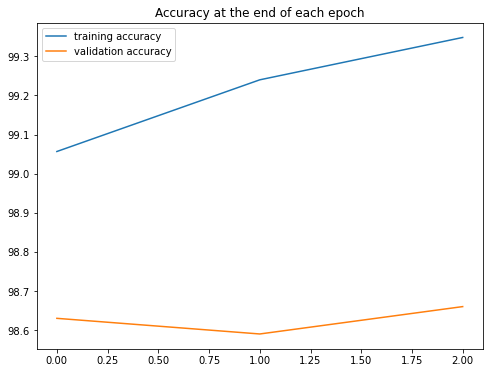

In [35]:
plt.figure(figsize = (8, 6))
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Evaluate entire test data

In [37]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [39]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        pred_class = torch.max(y_val, 1)[1]
        correct += (pred_class == y_test).sum()

In [40]:
print(f'Accuracy: {correct.item()/len(test_data)}')

Accuracy: 0.9866


In [42]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(pred_class.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 966    0    1    0    0    0    0    0    0    0]
 [   1 1122    0    1    0    0    0    4    0    2]
 [   2    0 1017    0    0    0    0    2    2    0]
 [   0    1    0  993    0    7    0    0    1    1]
 [   0    1    2    0  972    0    1    1    1    3]
 [   0    0    0    4    0  878    5    0    1    7]
 [   7    7    0    0    3    1  951    0    1    0]
 [   2    2   10    8    0    1    0 1018    2    6]
 [   1    2    2    4    1    4    1    1  965    6]
 [   1    0    0    0    6    1    0    2    1  984]]


### Evaluation on single data

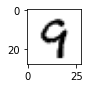

In [43]:
x = 150
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [44]:
'''
As we don't any dropout or regularization layers during testing or evaluation, running model.eval() makes
sure these layers are turned off and the network is ready to be tested.
'''
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
